Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.1A\Pi_data_10C_0.1A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.2A\Pi_data_10C_0.2A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.3A\Pi_data_10C_0.3A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.4A\Pi_data_10C_0.4A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.5A\Pi_data_10C_0.5A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.6A\Pi_data_10C_0.6A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.7A\Pi_data_10C_0.7A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.8A\Pi_data_10C_0.8A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_0.9A\Pi_data_10C_0.9A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_1.0A\Pi_data_10C_1.0A.npy
Loading data from: C:\Users\adelpasand\bmcs_training_data\10C_1.1A\Pi_data_10C_1.1A.npy
Loading data from: C:\Users\adel

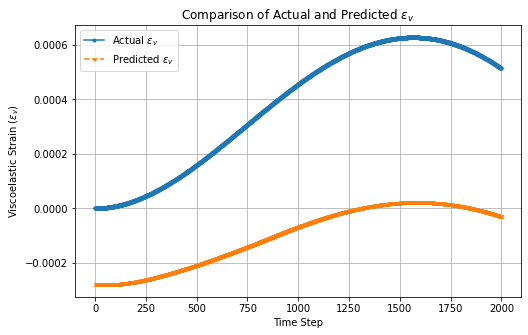

In [7]:
import os
import numpy as np
from ml_eps_v_predictor import *
import torch
import matplotlib.pyplot as plt
from pathlib import Path

# Define data directory

data_root_dir = Path(os.path.expanduser("~")) / "bmcs_training_data"
dataset = ViscoelasticDataset(data_root_dir, normalize=True)

# Load the .npy file
file_path = data_root_dir / '1C_0.1A' / 'Pi_data_1C_0.1A.npy'
sample_data = np.load(file_path)

# Extract input and target values
eps_t = sample_data[:-1, 0]  # Current step strain
dd_eps_t = sample_data[:-1, 1]  # Current step strain rate
eps_v_t = sample_data[:-1, 2]  # Current step viscoelastic strain
d_t = sample_data[:-1, 3]  # Current step time or damage variable

# Target: next step viscoelastic strain
eps_v_next = sample_data[1:, 2]

# Prepare input tensor
input_tensor = np.column_stack((eps_t, dd_eps_t, eps_v_t, d_t))

# Normalize inputs
mean = dataset.mean
std = dataset.std
input_normalized = (input_tensor - mean) / (std + 1e-8)  # Avoid division by zero
input_tensor = torch.tensor(input_normalized, dtype=torch.float32)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VE_TimeIntegrationPredictor().to(device)
model.load_state_dict(torch.load("ve_ivp_e100_b2000.pth", map_location=device))
model.eval()

# Move input to device
input_tensor = input_tensor.to(device)

# Make predictions
with torch.no_grad():
    predictions = model(input_tensor)
predicted_eps_v = predictions.cpu().numpy().flatten()

# Plot actual vs. predicted viscoelastic strain
plt.figure(figsize=(8, 5))
plt.plot(eps_v_next, label='Actual $\epsilon_v$', linestyle='-', marker='o', markersize=3)
plt.plot(predicted_eps_v, label='Predicted $\epsilon_v$', linestyle='--', marker='x', markersize=3)
plt.xlabel("Time Step")
plt.ylabel("Viscoelastic Strain ($\epsilon_v$)")
plt.legend()
plt.title("Comparison of Actual and Predicted $\epsilon_v$")
plt.grid()
plt.show()
